<a href="https://colab.research.google.com/github/nv-hiep/nguyen_et_al_2019/blob/main/HI_decomposition_nguyen_et_al_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [18]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

if not tf.config.list_physical_devices('GPU'):
    print('No GPU was detected. LSTMs and CNNs can be very slow without a GPU.')
    if IS_COLAB:
        print('Go to Runtime > Change runtime and select a GPU hardware accelerator.')

# Common imports
import os
import shutil
import itertools
import glob
import numpy as np
import matplotlib.image as mpimg
import pandas as pd

import string
import pickle

from tqdm import tqdm
from time import time
from PIL import Image


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

In [2]:
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# !pip install latex

# Connect to Google Drive

In [4]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Tue Jun 29 08:07:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [6]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/nguyen_et_al_2019/
!ls

/content/gdrive/My Drive/Colab Notebooks/nguyen_et_al_2019
fitted_parameters			  images	   Source_list.gsheet
HI_decomposition_nguyen_et_al_2019.ipynb  scripts
HI_spectra				  Source_list.csv


In [7]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/nguyen_et_al_2019


## Paths to Data Directories

In [8]:
PROJECT_PATH       = '/content/gdrive/My Drive/Colab Notebooks/nguyen_et_al_2019'
SPECTRA_PATH       = os.path.join( PROJECT_PATH, 'HI_spectra' )
FITTED_PARAMS_PATH = os.path.join( PROJECT_PATH, 'fitted_parameters' )

CNM_params  = os.path.join( FITTED_PARAMS_PATH, 'CNM_fitted_parameters', 'CNM_Gaussian_parameters.fits' )
WNM_params  = os.path.join( FITTED_PARAMS_PATH, 'WNM_fitted_parameters', 'WNM_Gaussian_parameters.fits' )

# List of sources

In [21]:
df = pd.read_csv(os.path.join( PROJECT_PATH, 'Source_list.csv' ))
pd.set_option('display.max_rows', df.shape[0]+1)

In [22]:
df

,Source name,R.A (J2000),DEC (J2000),l(deg),b(deg),Flux(1.4GHz) in Jy,Tsky (K)
0,J034053+073525 (4C+07.13),03:40:53.73,07:35:25.40,178.87,-36.27,1.01,4.07
1,J032153+122114 (PKS0319+12),03:21:53.11,12:21:14.00,170.59,-36.24,1.91,4.51
2,J032723+120835 (4C+11.15),03:27:23.11,12:08:35.80,171.98,-35.48,1.21,4.17
3,J031857+162833 (4C+16.09),03:18:57.77,16:28:33.10,166.64,-33.60,8.03,6.93
4,J033626+130233 (3C090),03:36:26.56,13:02:33.20,173.15,-33.29,1.99,4.67
5,J035613+130535,03:56:13.81,13:05:35.80,177.02,-29.78,0.89,4.14
6,J035900+143622 (3C096),03:59:00.91,14:36:22.50,176.27,-28.26,1.20,4.37
7,J042725+085330 (4C+08.15),04:27:25.05,08:53:30.30,186.21,-26.51,0.94,4.08
8,J032504+244445 (4C+24.06),03:25:04.35,24:44:46,161.92,-26.26,0.81,4.13
9,J035633+190034 (4C+18.11),03:56:33.46,19:00:34.60,172.23,-25.66,1.05,4.15


# Plot Spectra

In [9]:
src       = '4C+07.13'
file_path = os.path.join( SPECTRA_PATH, src + '.fits' )

In [10]:
data, header = fits.getdata(file_path, header=True)
for x in header:
    print(x, header[x])

print()
hdr = fits.getheader(file_path)
for x in hdr:
    print(x, hdr[x])

XTENSION BINTABLE
BITPIX 8
NAXIS 2
NAXIS1 88
NAXIS2 1118
PCOUNT 0
GCOUNT 1
TFIELDS 11
TTYPE1 vlsr_tau
TFORM1 D
TUNIT1 km/s
TTYPE2 emt
TFORM2 D
TTYPE3 sigemt
TFORM3 D
TTYPE4 vlsr_fitcnm
TFORM4 D
TUNIT4 km/s
TTYPE5 fitcnm
TFORM5 D
TTYPE6 vlsr_TB
TFORM6 D
TUNIT6 km/s
TTYPE7 TB
TFORM7 D
TUNIT7 K
TTYPE8 sigTB
TFORM8 D
TUNIT8 K
TTYPE9 TB_tot_fit
TFORM9 D
TUNIT9 K
TTYPE10 TB_WNM_fit
TFORM10 D
TUNIT10 K
TTYPE11 TB_CNM_fit
TFORM11 D
TUNIT11 K

SIMPLE True
BITPIX 8
NAXIS 0
EXTEND True
V1 -100.0
V2 -80.0
V3 60.0
V4 80.0
GLON 178.87378
GLAT -36.27019
RA50 3.6369
DEC50 7.43024
NAME 4C+07.13
NICKNAME SRC24_T
NCNM 5
NWNM 4
N(HI) 16.57183213200462
sig_N(HI) 0.8893091573162663
N(HI)_thin 13.6900885438982
sig_N(HI)_thin 0.03840548052712473
N(HI)_CNM_sum 7.336882012952118
sig_N(HI)_CNM_sum 0.6755079349258214
N(HI)_WNM_sum 9.234950119052506
sig_N(HI)_WNM_sum 0.578411451424347
sigfit_CNM 0.01181299395661283
sigfit_WNM 0.121084628005026
FLUX 1.014
TSKY 4.06935034179688
TSKY_FIT 4.058424822170094
EMTNOISE 0.

## Plot absorption spectra

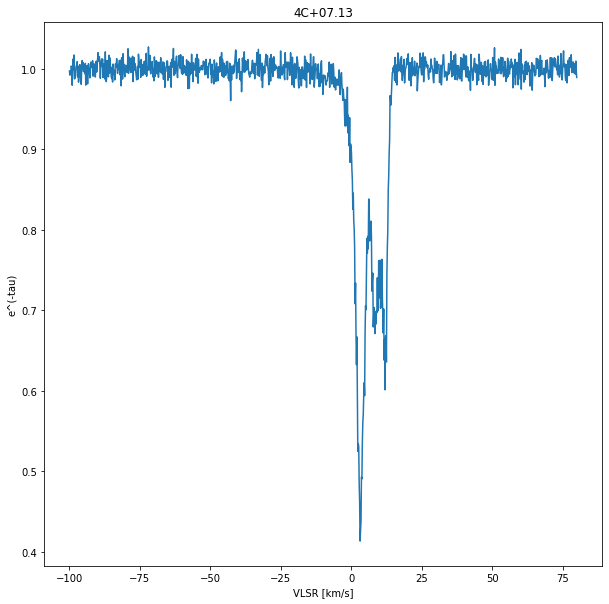

In [11]:
plt.figure(figsize=(10,10))

plt.title( src )
plt.xlabel( 'VLSR [km/s]' )
plt.ylabel( 'e^(-tau)' )

plt.plot(data['vlsr_tau'], data['emt'])
plt.show()

## Plot CNM components

In [12]:
## Multiple (N) Gaussians + offset. ##
 #
 # params list  v    VLSR
 # params float zr   estimated constant zero offset of the data points.
 # params list  h    the array of N estimated heights of the Gaussians.
 # params list  v0   the array of N estimated centers of the Gaussians.
 # params list  w    the array of N estimated halfwidths of the Gaussians.
 #
 # return 1-D-array  tf  The calculated points.
 #
 # version 01/2017
 # author Nguyen Van Hiep ##
def gfunc(v, zr, h, v0, w):
  dp600 = np.float64(0.60056120)

  if(np.isscalar(v)):
    v  = np.array([v], dtype='float64')

  if(np.isscalar(h)):
    h  = np.array([h], dtype='float64')

  if(np.isscalar(v0)):
    v0 = np.array([v0], dtype='float64')

  if(np.isscalar(w)):
    w  = np.array([w], dtype='float64')

  #DETERMINE NR OF GAUSSIANS...
  ng = len(h)

  ret = 0.*v + zr
  for i in range(ng):
    if (w[i] > 0.):
      ret = ret + h[i]*np.exp(- ( (v-v0[i])/(dp600*w[i]))**2)

  return ret

In [13]:
## READ CNM components for all sources
data, header = fits.getdata(CNM_params, header=True)
for x in header:
    print (x, header[x])

print()
hdr          = fits.getheader(CNM_params)
for x in hdr:
    print (x, hdr[x])

srcname = data['NAME']
idx     = np.where( srcname == src)[0]
ghgtc   = data['TAU0'][idx]
gcenc   = data['VCEN'][idx]
gwidc   = data['FWHM0'][idx]

XTENSION BINTABLE
BITPIX 8
NAXIS 2
NAXIS1 158
NAXIS2 349
PCOUNT 0
GCOUNT 1
TFIELDS 15
TTYPE1 NAME
TFORM1 30A
TTYPE2 NICKNAME
TFORM2 30A
TTYPE3 TAU0
TFORM3 D
TTYPE4 SIG_TAU0
TFORM4 D
TTYPE5 FWHM0
TFORM5 D
TUNIT5 km/s
TTYPE6 SIG_FWHM0
TFORM6 D
TUNIT6 km/s
TTYPE7 VCEN
TFORM7 D
TUNIT7 km/s
TTYPE8 SIG_VCEN
TFORM8 D
TUNIT8 km/s
TTYPE9 Ts
TFORM9 D
TUNIT9 K
TTYPE10 SIG_Ts
TFORM10 D
TUNIT10 K
TTYPE11 ORDER
TFORM11 I
TTYPE12 N(HI)_CNM_CPNTS
TFORM12 D
TUNIT12 1e20 cm-2
TTYPE13 SIG_N(HI)_CNM_CPNTS
TFORM13 D
TUNIT13 1e20 cm-2
TTYPE14 TKMAX
TFORM14 D
TUNIT14 K
TTYPE15 SIG_TKMAX
TFORM15 D
TUNIT15 K

SIMPLE True
BITPIX 8
NAXIS 0
EXTEND True
TELE Arecibo
CMT1 Nguyen et al. 2019
CMT2 N(HI)_CNM_CPNTS and SIG_N(HI)_CNM_CPNTS are N(HI) and its error for each CNM component


In [14]:
## READ SPECTRUM OF A SOURCE
data, header = fits.getdata(file_path, header=True)
hdr          = fits.getheader(file_path)

vlsr         = data['vlsr_tau']
emt          = data['emt']
sigemt       = data['sigemt']

xfitcnm      = data['vlsr_fitcnm']
gfitcnm      = data['fitcnm']
gresid1      = emt - gfitcnm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


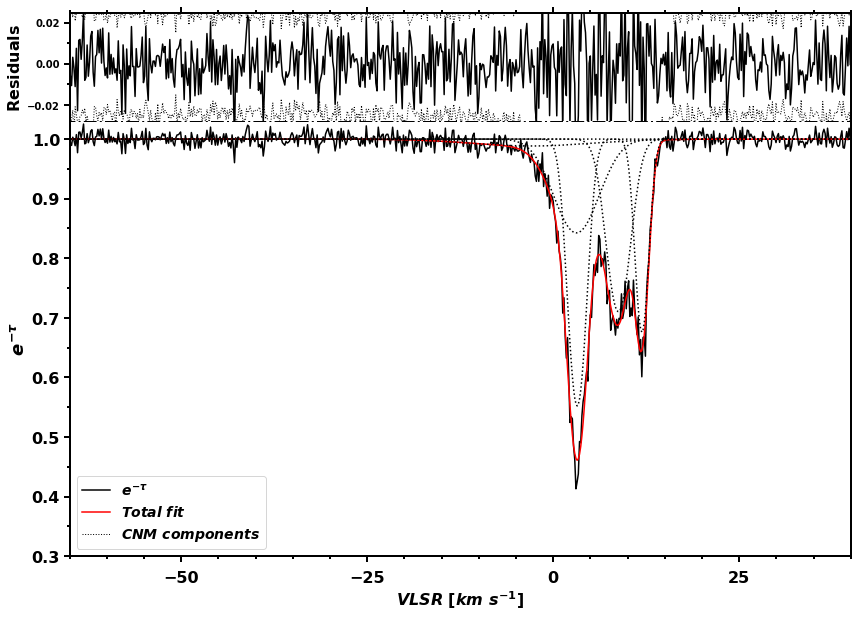

In [15]:
## Plot Figure
fts  = 36
lbsz = 16
lgds = 14

xlim     = [-65., 40.]
ylime    = [-3., 63.]
ylimeres = [-3., 3.5]
ylima    = [0.3, 1.03]
ylimares = [-0.028, 0.025]

plt.rc('font', weight='bold')
# plt.rc('text', usetex=True)    # uncomment this to make better figure, need to install latex for python
plt.rc('xtick', labelsize=15)
# plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath'] # uncomment this to make better figure, need to install latex for python
mpl.rcParams['axes.linewidth']      = 2.

## Figures
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,10), sharey=False, sharex=False)

## Absorption
major_xticks = np.arange(-100., 100., 25.)
minor_xticks = np.arange(-100., 100., 5.)
major_yticks = np.arange(0.2, 1.2, 0.1)
minor_yticks = np.arange(0.2, 1.2, 0.05)

ax.plot(vlsr, emt, 'k-', label=r'$e^{-\tau}$')
ax.plot(xfitcnm, gfitcnm, 'r-', label='$Total\ fit$')

divider = make_axes_locatable(ax)
axres   = divider.append_axes('top', size='25%', pad=0, sharex=ax)
ax.figure.add_axes(axres)

for ceni,hgti,widi in zip(gcenc, ghgtc, gwidc):
    ax.plot( vlsr, np.exp(-gfunc(vlsr, 0., [hgti], [ceni], [widi]) ), 'k:', label='')

ax.plot(-100., 1., color='k', ls=':', lw=1, label='$CNM\ components$')
# ax.fill_between(vlsr, emt-sigemt, emt+sigemt, color='gray', label='')

ax.set_ylabel(r'$e^{-\tau}$', fontsize = 18)
ax.set_xlabel(r'$VLSR\ [km\ s^{-1}]$', fontsize = 16)

ax.set_yticks(major_yticks)
ax.set_yticks(minor_yticks, minor=True)
ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor=True)
ax.tick_params(axis='x', labelsize=lbsz, pad=8)
ax.tick_params(axis='y', labelsize=lbsz)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)
ax.legend(loc='lower left', fontsize=lgds)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x',  which='both', bottom=True, top=False, labeltop=False)
ax.axhline(y=ylima[1], xmin=-100, xmax=100, c='k', ls='-.', linewidth=2)

ax.set_xlim(xlim)
ax.set_ylim(ylima)

# Axe - residuals
major_yticks = np.arange(-0.06, 0.06, 0.02)
minor_yticks = np.arange(-0.06, 0.06, 0.01)
axres.plot(vlsr, -sigemt, color='k', ls=':', lw=1, label='')
axres.plot(vlsr, sigemt, color='k', ls=':', lw=1, label='')
axres.plot(xfitcnm, gresid1, color='k', ls='-', label='$Residuals$')

axres.set_ylabel(r'$\mathrm{Residuals}$', fontsize = 16)
axres.set_yticks(major_yticks)
axres.set_yticks(minor_yticks, minor=True)
axres.set_xticks(major_xticks)
axres.set_xticks(minor_xticks, minor=True)
axres.tick_params(axis='x',  which='both', bottom=False, top=True, labelbottom=False)
axres.tick_params(which='both', width=2)
axres.tick_params(which='major', length=6)
axres.tick_params(which='minor', length=3)
axres.grid(False)
axres.spines['bottom'].set_visible(False)
axres.set_xlim(xlim)
axres.set_ylim(ylimares)
# plt.savefig(src+'.png', bbox_inches='tight', pad_inches=0.09, format='png', dpi=60)
plt.show()

## Plot WNM components

In [16]:
## READ WNM components for all sources
data, header = fits.getdata(WNM_params, header=True)
for x in header:
    print(x, header[x])

print()
hdr          = fits.getheader(WNM_params)
for x in hdr:
    print(x, hdr[x])

srcname = data['NAME']
idx     = np.where( srcname == src)[0]
ghgtw   = data['HGT'][idx]
gcenw   = data['VCEN'][idx]
gwidw   = data['FWHM0'][idx]
fwnm    = data['FWNM'][idx]

## READ SPECTRUM OF A SOURCE
data, header = fits.getdata(file_path , header=True)
hdr          = fits.getheader(file_path)

vlsr         = data['vlsr_TB']
te           = data['TB']
sigtexp      = data['sigTB']

gtb_tot_fit = data['TB_tot_fit']
gtb_wnm_tot = data['TB_WNM_fit']
gtb_cnm_tot = data['TB_CNM_fit']
gresid2     = te - gtb_tot_fit

XTENSION BINTABLE
BITPIX 8
NAXIS 2
NAXIS1 156
NAXIS2 327
PCOUNT 0
GCOUNT 1
TFIELDS 14
TTYPE1 NAME
TFORM1 30A
TTYPE2 NICKNAME
TFORM2 30A
TTYPE3 HGT
TFORM3 D
TTYPE4 SIG_HGT
TFORM4 D
TTYPE5 FWHM0
TFORM5 D
TUNIT5 km/s
TTYPE6 SIG_FWHM0
TFORM6 D
TUNIT6 km/s
TTYPE7 VCEN
TFORM7 D
TUNIT7 km/s
TTYPE8 SIG_VCEN
TFORM8 D
TUNIT8 km/s
TTYPE9 FWNM
TFORM9 D
TUNIT9 K
TTYPE10 SIG_FWNM
TFORM10 D
TUNIT10 K
TTYPE11 N(HI)_WNM_CPNTS
TFORM11 D
TUNIT11 1e20 cm-2
TTYPE12 SIG_N(HI)_WNM_CPNTS
TFORM12 D
TUNIT12 1e20 cm-2
TTYPE13 TKMAX
TFORM13 D
TUNIT13 K
TTYPE14 SIG_TKMAX
TFORM14 D
TUNIT14 K

SIMPLE True
BITPIX 8
NAXIS 0
EXTEND True
TELE Arecibo
CMT1 Nguyen et al. 2019
CMT2 N(HI)_WNM_CPNTS and SIG_N(HI)_WNM_CPNTS are N(HI) and its error for each CNM component


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


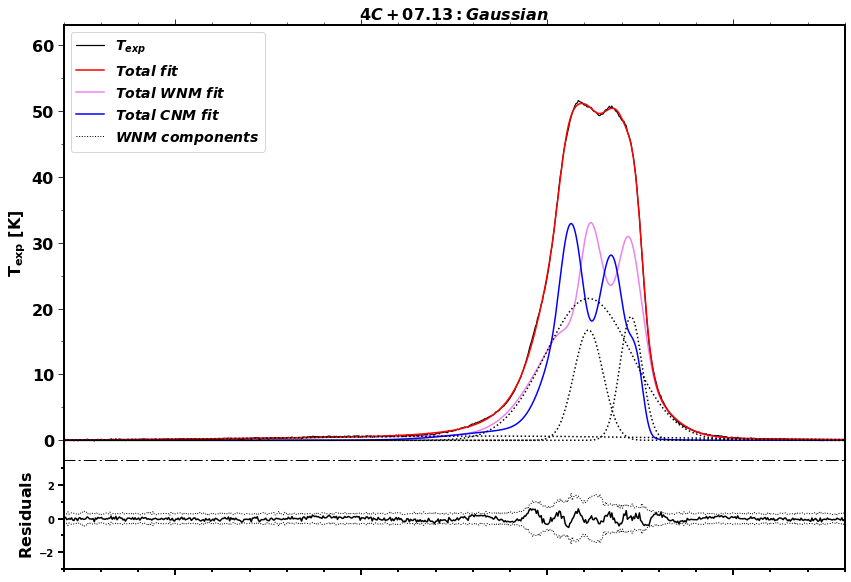

In [17]:
## Plot
fts  = 36
lbsz = 16
lgds = 14

xlim     = [-65., 40.]
ylime    = [-3., 63.]
ylimeres = [-3., 3.5]
ylima    = [0.3, 1.03]
ylimares = [-0.028, 0.025]

plt.rc('font', weight='bold')
# plt.rc('text', usetex=True)                                                 # uncomment this to make better figure, need to install latex for python
plt.rc('xtick', labelsize=15)
# plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']    # uncomment this to make better figure, need to install latex for python
mpl.rcParams['axes.linewidth']      = 2.

## Figures
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,10), sharey=False, sharex=False)

## Emission
major_xticks = np.arange(-100., 100., 25.)
minor_xticks = np.arange(-100., 100., 5.)
major_yticks = np.arange(-20., 100., 10.)
minor_yticks = np.arange(-20., 100., 5.)

divider = make_axes_locatable(ax)
axres   = divider.append_axes('bottom', size='25%', pad=0, sharex=ax)
ax.figure.add_axes(axres)
# axres.spines['bottom'].set_visible(False)

ax.plot(vlsr, te, 'k-', lw=1.2, label=r'$T_{exp}$')
ax.plot(vlsr, gtb_tot_fit, 'r-', label=r'$Total\ fit$')
ax.plot(vlsr, gtb_wnm_tot, color='violet', ls='-', zorder=-1, label=r'$Total\ WNM\ fit$')
ax.plot(vlsr, gtb_cnm_tot, color='b', ls='-', zorder=-1, label=r'$Total\ CNM\ fit$')
# ax.fill_between(vlsr, te-sigtexp, te+sigtexp, color='gray', label=r'')
ax.plot(-100., 0., color='k', ls=':', lw=1, label='$WNM\ components$')

for ceni, hgti, widi in zip(gcenw, ghgtw, gwidw):
    ax.plot( vlsr, gfunc(vlsr, 0., [hgti], [ceni], [widi]), 'k:', label='')

ax.set_title('$'+src+': Gaussian$', fontsize=16)
ax.set_ylabel(r'$\mathrm{T_{exp}\ [K]}$', fontsize = 16)

ax.set_yticks(major_yticks)
ax.set_yticks(minor_yticks, minor=True)
ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor=True)
ax.tick_params(which='y', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)
# ax.tick_params(axis='x', labelsize=lbsz, pad=8, bottom=False, labelbottom=False)
ax.tick_params(axis='y', labelsize=lbsz)
ax.tick_params(axis='x',  which='both', bottom=False, top=True, labelbottom=False)
ax.grid(False)
ax.set_xticks([])
ax.spines['bottom'].set_visible(False)

ax.set_xlim(xlim)
ax.set_ylim(ylime)
ax.legend(loc='upper left', fontsize=lgds)


# Axe - residuals
major_xticks = np.arange(-100., 100., 25.)
minor_xticks = np.arange(-100., 100., 5.)
major_yticks = np.arange(-6., 6., 2.)
minor_yticks = np.arange(-6., 6., 1.)
axres.plot(vlsr, -sigtexp, color='k', ls=':', lw=1, label='')
axres.plot(vlsr, sigtexp, color='k', ls=':', lw=1, label='')
axres.plot(vlsr, gresid2, color='k', ls='-', label='$Residuals$')

axres.set_ylabel(r'$\mathrm{Residuals}$', fontsize = 16)
axres.set_yticks(major_yticks)
axres.set_yticks(minor_yticks, minor=True)
axres.set_xticks(major_xticks)
axres.set_xticks(minor_xticks, minor=True)
axres.tick_params(axis='x',  which='both', bottom=True, top=False, labelbottom=False)
axres.tick_params(which='both', width=2)
axres.tick_params(which='major', length=6)
axres.tick_params(which='minor', length=3)
axres.grid(False)
axres.spines['top'].set_visible(False) #axres.spines['top'].set_linewidth(0.5)
axres.axhline(y=ylimeres[1], xmin=-100, xmax=100, c='k', ls='-.', linewidth=2)
axres.set_xlim(xlim)
axres.set_ylim(ylimeres)
# plt.savefig(src+'_Texp.png', bbox_inches='tight', pad_inches=0.09, format='png', dpi=60)
plt.show()